# Investigation Two Multivariate Data Prediction
The data used in this example are taken from four temperature sensors situation on the fore and aft of a large tank of water. The data is indexed on the integers and was read from the field every two seconds.  The application demonstrates the predictive capabilities of the __trcrpm__ in a multivariate setting. Readings are in degrees Celsius. 

The ~2000 samples on each sensor are normal/expected. 

The intent of this investigation is to determine whether or not __trcrpm__ meaningful estimates from the predictive posterior with little or no tuning.

This code is based on the __trcrpm__ tutorials. It is included to demonstrate the basic functionality of the code base, as well as to highlight intuitively, the trcrpm algorithm.

In [21]:
# Import the required python libraries imported
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from trcrpm import TRCRP_Mixture

In [38]:
# Indicates to jupyer how the plots are to be displayed and sized
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 15]

In [23]:
# Read and inspect data
data = pd.read_csv("../data/grp2.csv", index_col=0)
data.columns
data.head()

,group_2.0,group_2.1,group_2.2,group_2.3
0,62.224842,61.827423,62.578228,62.666590
1,62.224842,61.827423,62.578228,62.666590
2,61.981956,61.959880,62.777058,62.578228
3,62.048195,61.783270,62.511960,62.136513
4,62.180680,61.893650,62.578228,62.445694


In [24]:
# Split the data into training and helf back
held_back = 100
data_train = data.iloc[0:held_back, :]
data_validate = data.iloc[held_back:-1, :]

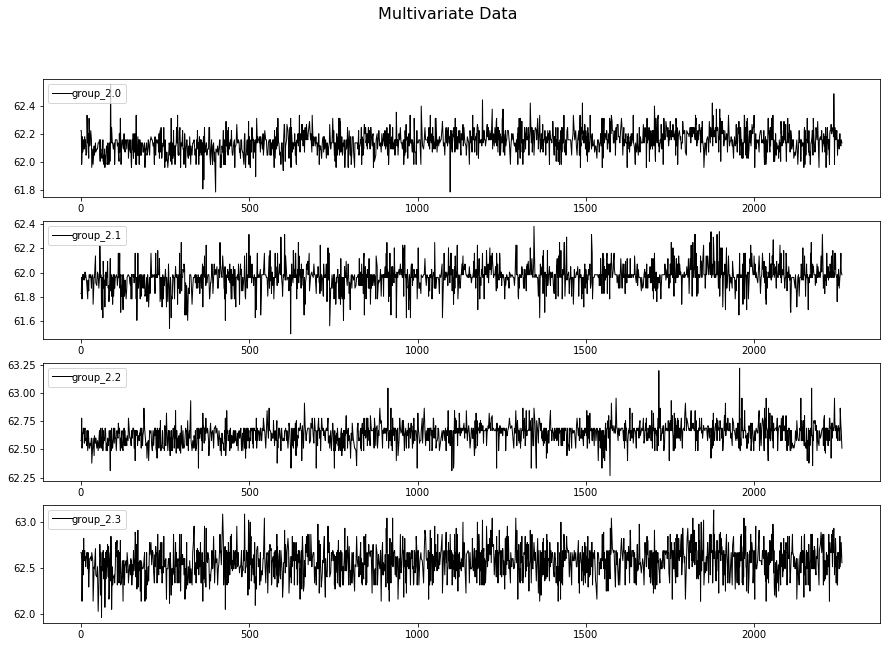

In [25]:
# Plot the data
fig, axes = plt.subplots(nrows=len(data.columns))
fig.suptitle('Multivariate Data', fontsize=16)
for ax, variable in zip(axes, data.columns):
    index = list(data.columns).index(variable)
    x_observed = data.index
    y_observed = data.loc[:,variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    ax.legend(loc='upper left', handletextpad=0)

In [26]:
# Provide entropy ~ number of time series
rng = np.random.RandomState(4)
# Create TRCRP_Mixture model object, with 8 MCMC chaine, and a time dependency over the previous 200 samples
model = TRCRP_Mixture(chains=4, lag=10, variables=data_train.columns, rng=rng)
# Incorporate the data set into the model
model.incorporate(data_train)
# Run MCMC inference the latent state for #steps full Gibbs sweeps through all kernels
model.resample_all(steps=50)
# Run empirical Bayes on variable hyperparameters for full Gibbs sweeps through all kernels
model.resample_hyperparameters(steps=50);
# Set up an index/grid, and number of samples desire per index/grid point to run a simulation
probes = list(data_validate.index[:50])
numsamples = 500
samples = model.simulate(probes, model.variables, numsamples)

Completed: 50 iterations in 8.489002 seconds.
Completed: 50 iterations in 11.087884 seconds.
Completed: 50 iterations in 12.990774 seconds.
Completed: 50 iterations in 19.704213 seconds.
Completed: 50 iterations in 130.733105 seconds.
Completed: 50 iterations in 153.581851 seconds.
Completed: 50 iterations in 162.680820 seconds.
Completed: 50 iterations in 172.480363 seconds.


In [27]:
# Helper function to plot model predictions from the posterior
def plot_predictions(simulations, variable, ax, states_from_chain=None):
    index = model.variables.index(variable)
    # Plot the observed data.
    x_observed = list(model.dataset.index)
    y_observed = list(model.dataset.loc[:,variable])
    ax.plot(x_observed, y_observed, color='k', linewidth=1)
    ax.set_title('Forecast data for %s' % (variable,))
    # Plot 5--95confidence bands around the simulated data. 
    samples = simulations[:,:,index]
    median = np.median(samples, axis=0)
    ax.plot([x_observed[-1], probes[0]], [y_observed[-1], median[0]],
        color='k')
    ax.plot(probes, median, color='k', label='Mean Forecast')
    ax.fill_between(
        probes,
        np.percentile(samples, 5, axis=0),
        np.percentile(samples, 95, axis=0),
        color='gray',
        alpha=0.5)
    #  Plot the held-out data.
    ax.scatter(probes, data_validate.loc[probes,variable],
        color='r', marker='x', label='Held-out Data')
    # Add the legend.
    ax.legend(loc='upper left', handletextpad=0)
    

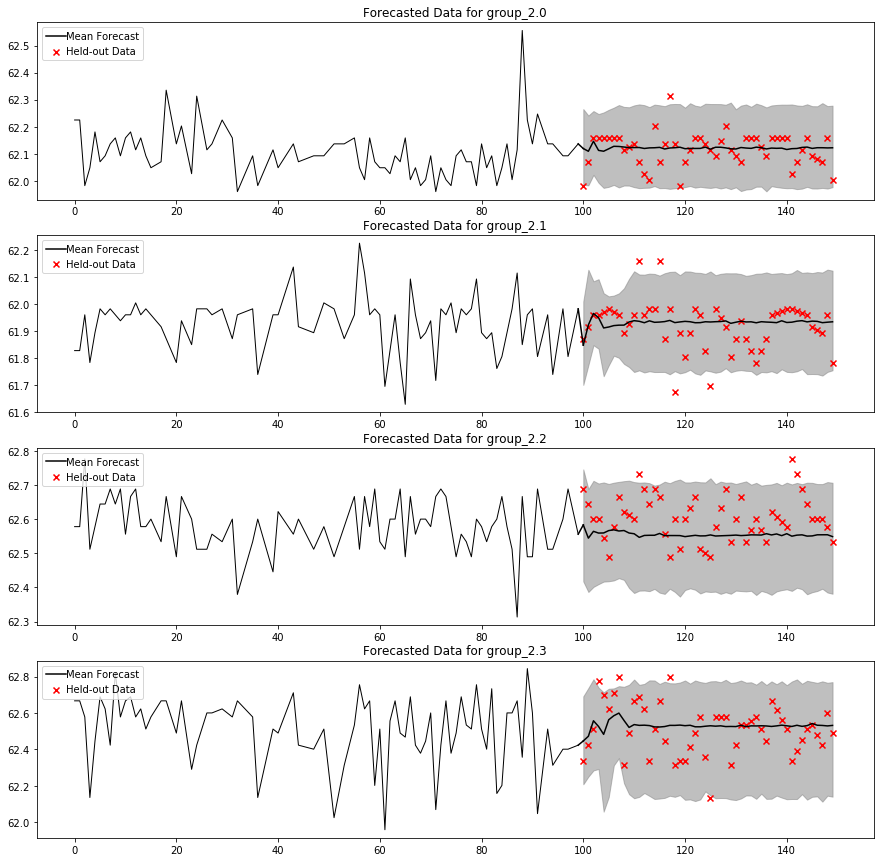

In [39]:
# Plot the data
fig, axes = plt.subplots(nrows=len(data.columns))
for ax, variable in zip(axes, data.columns):
    index = list(data.columns).index(variable)
    plot_predictions(samples, variable, ax)